This is the project for Machine Learning at UA. 
First, we import the datasets into the notebook after we downloaded the files from the website.

## Data Import

In [49]:
# import necessary libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

%matplotlib inline


# read csv files
cleveland_df   = pd.read_csv("processed.cleveland.data", header=None, na_values =["?", -9.0])
switzerland_df = pd.read_csv("processed.switzerland.data", header=None, na_values =["?", -9.0])
va_df          = pd.read_csv("processed.va.data", header=None, na_values =["?", -9.0])
hungarian_df   = pd.read_csv("processed.hungarian (1).data", header=None, na_values =["?", -9.0])

Now we need to organize the data and add headers to the data frames. 

In [50]:
#add a column to keep track of the source of the data
cleveland_df["Source"] = "cleveland"
switzerland_df["Source"] = "switzerland"
va_df["Source"] = "va"
hungarian_df["Source"] = "hungarian"

In [51]:
# add headers to the data frames
headers = {0 : "age",
               1 : "sex",
               2 : "cp",
               3 : "trestbps",
               4 : "chol",
               5 : "fbs",
               6 : "restecg",
               7 : "thalach",
               8 : "exang",
               9 : "oldpeak",
               10 : "slope",
               11 : "ca",
               12 : "thal",
               13 : "diagnosis"}

cleveland_df = cleveland_df.rename(columns=headers)
switzerland_df = switzerland_df.rename(columns=headers)
va_df = va_df.rename(columns=headers)
hungarian_df = hungarian_df.rename(columns=headers)

Now we want to combine the different datasets from Cleveland, Switzerland, Va and Hungary into one big dataset. 

In [4]:
heart_disease_df = pd.concat([cleveland_df, switzerland_df, va_df, hungarian_df])

Next, we want to look at some details of the dataset. 

In [5]:
print(heart_disease_df.head())
print(heart_disease_df.info())

    age  sex   cp  trestbps   chol  fbs  restecg  thalach  exang  oldpeak  \
0  63.0  1.0  1.0     145.0  233.0  1.0      2.0    150.0    0.0      2.3   
1  67.0  1.0  4.0     160.0  286.0  0.0      2.0    108.0    1.0      1.5   
2  67.0  1.0  4.0     120.0  229.0  0.0      2.0    129.0    1.0      2.6   
3  37.0  1.0  3.0     130.0  250.0  0.0      0.0    187.0    0.0      3.5   
4  41.0  0.0  2.0     130.0  204.0  0.0      2.0    172.0    0.0      1.4   

   slope   ca  thal  diagnosis     Source  
0    3.0  0.0   6.0          0  cleveland  
1    2.0  3.0   3.0          2  cleveland  
2    2.0  2.0   7.0          1  cleveland  
3    3.0  0.0   3.0          0  cleveland  
4    1.0  0.0   3.0          0  cleveland  
<class 'pandas.core.frame.DataFrame'>
Int64Index: 920 entries, 0 to 293
Data columns (total 15 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   age        920 non-null    float64
 1   sex        920 non-null    float64
 2   cp 

Next, let's use the command from the lecture to describe the data. 

In [6]:
heart_disease_df.describe()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,diagnosis
count,920.000000,920.000000,920.000000,861.000000,890.000000,830.000000,918.000000,865.000000,865.000000,858.000000,611.000000,309.000000,434.000000,920.000000
mean,53.510870,0.789130,3.250000,132.132404,199.130337,0.166265,0.604575,137.545665,0.389595,0.878788,1.770867,0.676375,5.087558,0.995652
std,9.424685,0.408148,0.930969,19.066070,110.780810,0.372543,0.805827,25.926276,0.487941,1.091226,0.619256,0.935653,1.919075,1.142693
min,28.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,60.000000,0.000000,-2.600000,1.000000,0.000000,3.000000,0.000000
25%,47.000000,1.000000,3.000000,120.000000,175.000000,0.000000,0.000000,120.000000,0.000000,0.000000,1.000000,0.000000,3.000000,0.000000
50%,54.000000,1.000000,4.000000,130.000000,223.000000,0.000000,0.000000,140.000000,0.000000,0.500000,2.000000,0.000000,6.000000,1.000000
75%,60.000000,1.000000,4.000000,140.000000,268.000000,0.000000,1.000000,157.000000,1.000000,1.500000,2.000000,1.000000,7.000000,2.000000
max,77.000000,1.000000,4.000000,200.000000,603.000000,1.000000,2.000000,202.000000,1.000000,6.200000,3.000000,3.000000,7.000000,4.000000


Let's collect some more information concerning the dataset. 


In [7]:
print(heart_disease_df.shape)
print(heart_disease_df.size)

(920, 15)
13800


Some more analytics. There are 920 observations with 15 14 features each, resulting in one diagnosis.

In [8]:
heart_disease_df.corr(method = 'pearson')

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,diagnosis
age,1.000000,0.056889,0.166245,0.244253,-0.086234,0.233726,0.212719,-0.365778,0.201626,0.258243,0.155032,0.370416,0.137298,0.339596
sex,0.056889,1.000000,0.170392,0.001087,-0.197281,0.089191,-0.015612,-0.179320,0.181420,0.103930,0.125154,0.094123,0.373927,0.259342
cp,0.166245,0.170392,1.000000,0.025075,-0.132576,0.039838,0.031101,-0.349189,0.419384,0.244245,0.202989,0.214975,0.313150,0.397896
trestbps,0.244253,0.001087,0.025075,1.000000,0.092853,0.160235,0.098857,-0.104899,0.152328,0.161908,0.063387,0.093705,0.107555,0.122291
chol,-0.086234,-0.197281,-0.132576,0.092853,1.000000,0.024847,0.116494,0.236121,-0.034557,0.047734,-0.059276,0.051606,-0.179903,-0.231547
fbs,0.233726,0.089191,0.039838,0.160235,0.024847,1.000000,0.132347,-0.053386,0.029176,0.055277,0.092142,0.149539,0.105871,0.155533
restecg,0.212719,-0.015612,0.031101,0.098857,0.116494,0.132347,1.000000,0.053120,0.032331,0.118297,-0.014771,0.139154,-0.040084,0.140089
thalach,-0.365778,-0.179320,-0.349189,-0.104899,0.236121,-0.053386,0.053120,1.000000,-0.356439,-0.151174,-0.360622,-0.264094,-0.327360,-0.366265
exang,0.201626,0.181420,0.419384,0.152328,-0.034557,0.029176,0.032331,-0.356439,1.000000,0.392492,0.319424,0.127385,0.340737,0.388408
oldpeak,0.258243,0.103930,0.244245,0.161908,0.047734,0.055277,0.118297,-0.151174,0.392492,1.000000,0.421184,0.281817,0.254391,0.443084


Analyse the Pearson correlation coefficient, to find connections within the dataset. 

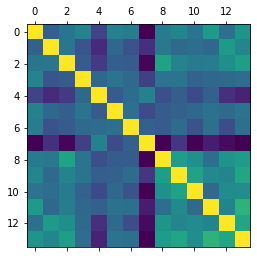

In [9]:
plt.matshow(heart_disease_df.corr())
plt.show()

In [10]:
rs = np.random.RandomState(0)
df = pd.DataFrame(rs.rand(10, 10))
corr = heart_disease_df.corr()
corr.style.background_gradient(cmap='coolwarm')

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,diagnosis
age,1.000000,0.056889,0.166245,0.244253,-0.086234,0.233726,0.212719,-0.365778,0.201626,0.258243,0.155032,0.370416,0.137298,0.339596
sex,0.056889,1.000000,0.170392,0.001087,-0.197281,0.089191,-0.015612,-0.179320,0.181420,0.103930,0.125154,0.094123,0.373927,0.259342
cp,0.166245,0.170392,1.000000,0.025075,-0.132576,0.039838,0.031101,-0.349189,0.419384,0.244245,0.202989,0.214975,0.313150,0.397896
trestbps,0.244253,0.001087,0.025075,1.000000,0.092853,0.160235,0.098857,-0.104899,0.152328,0.161908,0.063387,0.093705,0.107555,0.122291
chol,-0.086234,-0.197281,-0.132576,0.092853,1.000000,0.024847,0.116494,0.236121,-0.034557,0.047734,-0.059276,0.051606,-0.179903,-0.231547
fbs,0.233726,0.089191,0.039838,0.160235,0.024847,1.000000,0.132347,-0.053386,0.029176,0.055277,0.092142,0.149539,0.105871,0.155533
restecg,0.212719,-0.015612,0.031101,0.098857,0.116494,0.132347,1.000000,0.053120,0.032331,0.118297,-0.014771,0.139154,-0.040084,0.140089
thalach,-0.365778,-0.179320,-0.349189,-0.104899,0.236121,-0.053386,0.053120,1.000000,-0.356439,-0.151174,-0.360622,-0.264094,-0.327360,-0.366265
exang,0.201626,0.181420,0.419384,0.152328,-0.034557,0.029176,0.032331,-0.356439,1.000000,0.392492,0.319424,0.127385,0.340737,0.388408
oldpeak,0.258243,0.103930,0.244245,0.161908,0.047734,0.055277,0.118297,-0.151174,0.392492,1.000000,0.421184,0.281817,0.254391,0.443084


## Data Visualization

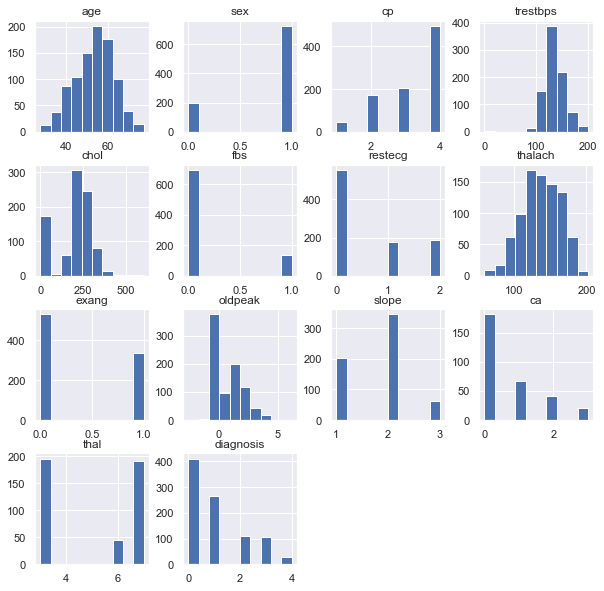

<Figure size 432x288 with 0 Axes>

In [11]:
sns.set()
heart_disease_df.hist(figsize=(10,10))
plt.show()
plt.savefig('heart_disease_hist.png', dpi=300, bbox_inches='tight')

<AxesSubplot:xlabel='diagnosis', ylabel='Count'>

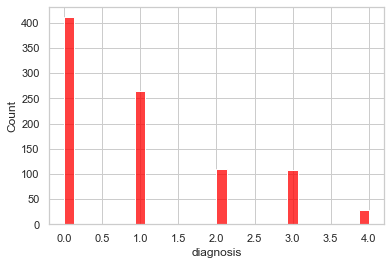

In [12]:
heart_disease_df.head()
sns.set_style('whitegrid')
sns.histplot(heart_disease_df['diagnosis'], kde = False, color ='red', bins = 30)

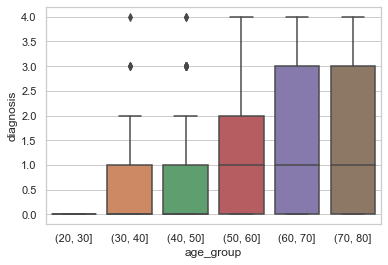

In [13]:
# Define the age ranges for grouping
age_bins = [20, 30, 40, 50, 60, 70, 80]

# Create a new column 'age_group' based on age bins
heart_disease_df['age_group'] = pd.cut(heart_disease_df['age'], bins=age_bins)

# Create the boxplot with age group on x-axis and diagnosis on y-axis
sns.boxplot(x='age_group', y='diagnosis', data=heart_disease_df)
heart_disease_df= heart_disease_df.drop('age_group', axis=1)

In [14]:
# Group the data by age and calculate the mean, median of a column for each group
# age_stats_df = heart_disease_df.groupby('age')['diagnosis'].agg(['mean', 'median']).reset_index()

# Plot the graph using seaborn lineplot
# sns.lineplot(x='age', y='mean', data=age_stats_df, label='Average')
#sns.lineplot(x='age', y='median', data=age_stats_df, label='Median')
#sns.lineplot(x='age', y='diagnosis', data=heart_disease_df, estimator=None, alpha=0.2, color='gray')

In [15]:
#sns.boxplot(x='ca',y='diagnosis',data=heart_disease_df)

## Plots for IEEE-Paper

Only Cleveland Dataframe.

In [52]:
cleveland_df.describe()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,diagnosis
count,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,299.000000,301.000000,303.000000
mean,54.438944,0.679868,3.158416,131.689769,246.693069,0.148515,0.990099,149.607261,0.326733,1.039604,1.600660,0.672241,4.734219,0.937294
std,9.038662,0.467299,0.960126,17.599748,51.776918,0.356198,0.994971,22.875003,0.469794,1.161075,0.616226,0.937438,1.939706,1.228536
min,29.000000,0.000000,1.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,1.000000,0.000000,3.000000,0.000000
25%,48.000000,0.000000,3.000000,120.000000,211.000000,0.000000,0.000000,133.500000,0.000000,0.000000,1.000000,0.000000,3.000000,0.000000
50%,56.000000,1.000000,3.000000,130.000000,241.000000,0.000000,1.000000,153.000000,0.000000,0.800000,2.000000,0.000000,3.000000,0.000000
75%,61.000000,1.000000,4.000000,140.000000,275.000000,0.000000,2.000000,166.000000,1.000000,1.600000,2.000000,1.000000,7.000000,2.000000
max,77.000000,1.000000,4.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.200000,3.000000,3.000000,7.000000,4.000000


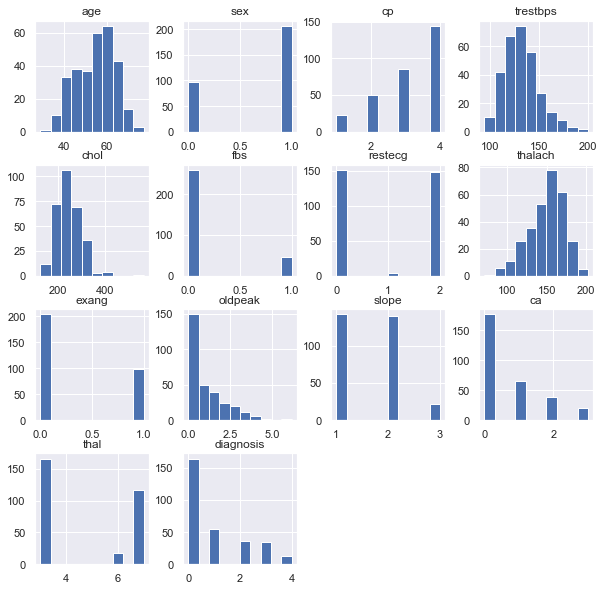

In [53]:
sns.set()
cleveland_df.hist(figsize=(10,10))
plt.savefig('heart_disease_hist.png', dpi=300, bbox_inches='tight')
plt.show()

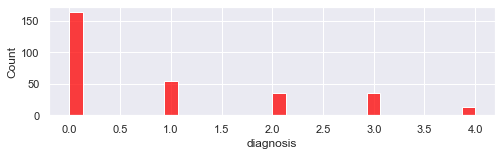

In [54]:
fig, ax = plt.subplots(figsize=(8, 2)) # Create a new figure with size (8, 2)
sns.set_style('whitegrid')
sns.histplot(cleveland_df['diagnosis'], kde=False, color='red', bins=30, ax=ax) # Add the plot to the specified axis
plt.savefig('diagnosis_distribution.png', dpi=300, bbox_inches='tight')

In [55]:
rs = np.random.RandomState(0)
df = pd.DataFrame(rs.rand(9, 9))
corr = cleveland_df.corr().round(3)
corr.style.background_gradient(cmap='coolwarm')

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,diagnosis
age,1.000000,-0.098000,0.104000,0.285000,0.209000,0.119000,0.149000,-0.394000,0.092000,0.204000,0.162000,0.363000,0.127000,0.223000
sex,-0.098000,1.000000,0.010000,-0.064000,-0.200000,0.048000,0.022000,-0.049000,0.146000,0.102000,0.038000,0.093000,0.381000,0.224000
cp,0.104000,0.010000,1.000000,-0.036000,0.072000,-0.040000,0.068000,-0.334000,0.384000,0.202000,0.152000,0.233000,0.265000,0.407000
trestbps,0.285000,-0.064000,-0.036000,1.000000,0.130000,0.175000,0.147000,-0.045000,0.065000,0.189000,0.117000,0.099000,0.134000,0.158000
chol,0.209000,-0.200000,0.072000,0.130000,1.000000,0.010000,0.171000,-0.003000,0.061000,0.047000,-0.004000,0.119000,0.014000,0.071000
fbs,0.119000,0.048000,-0.040000,0.175000,0.010000,1.000000,0.070000,-0.008000,0.026000,0.006000,0.060000,0.145000,0.071000,0.059000
restecg,0.149000,0.022000,0.068000,0.147000,0.171000,0.070000,1.000000,-0.083000,0.085000,0.114000,0.134000,0.128000,0.025000,0.184000
thalach,-0.394000,-0.049000,-0.334000,-0.045000,-0.003000,-0.008000,-0.083000,1.000000,-0.378000,-0.343000,-0.386000,-0.264000,-0.280000,-0.415000
exang,0.092000,0.146000,0.384000,0.065000,0.061000,0.026000,0.085000,-0.378000,1.000000,0.288000,0.258000,0.146000,0.330000,0.397000
oldpeak,0.204000,0.102000,0.202000,0.189000,0.047000,0.006000,0.114000,-0.343000,0.288000,1.000000,0.578000,0.296000,0.341000,0.504000


In [56]:
rs = np.random.RandomState(0)
df = pd.DataFrame(rs.rand(9, 9))
corr = cleveland_df.corr().round(3) # round to 3 decimal places
# Format the correlation matrix to display only the last 3 numbers
corr_style = corr.style.format("{:.3f}")

# Apply a color map to the correlation matrix
corr_heatmap = corr_style.background_gradient(cmap='coolwarm')
corr_heatmap

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,diagnosis
age,1.000,-0.098,0.104,0.285,0.209,0.119,0.149,-0.394,0.092,0.204,0.162,0.363,0.127,0.223
sex,-0.098,1.000,0.010,-0.064,-0.200,0.048,0.022,-0.049,0.146,0.102,0.038,0.093,0.381,0.224
cp,0.104,0.010,1.000,-0.036,0.072,-0.040,0.068,-0.334,0.384,0.202,0.152,0.233,0.265,0.407
trestbps,0.285,-0.064,-0.036,1.000,0.130,0.175,0.147,-0.045,0.065,0.189,0.117,0.099,0.134,0.158
chol,0.209,-0.200,0.072,0.130,1.000,0.010,0.171,-0.003,0.061,0.047,-0.004,0.119,0.014,0.071
fbs,0.119,0.048,-0.040,0.175,0.010,1.000,0.070,-0.008,0.026,0.006,0.060,0.145,0.071,0.059
restecg,0.149,0.022,0.068,0.147,0.171,0.070,1.000,-0.083,0.085,0.114,0.134,0.128,0.025,0.184
thalach,-0.394,-0.049,-0.334,-0.045,-0.003,-0.008,-0.083,1.000,-0.378,-0.343,-0.386,-0.264,-0.280,-0.415
exang,0.092,0.146,0.384,0.065,0.061,0.026,0.085,-0.378,1.000,0.288,0.258,0.146,0.330,0.397
oldpeak,0.204,0.102,0.202,0.189,0.047,0.006,0.114,-0.343,0.288,1.000,0.578,0.296,0.341,0.504


In [57]:
corr_matrix = cleveland_df.corr()

corr_matrix.style.background_gradient(cmap='coolwarm')

nmbr_features = 10

top_correlations = corr_matrix['diagnosis'].abs().sort_values(ascending=False)[1:nmbr_features+1]
print(top_correlations)

ca         0.518909
thal       0.509923
oldpeak    0.504092
thalach    0.415040
cp         0.407075
exang      0.397057
slope      0.377957
sex        0.224469
age        0.222853
restecg    0.183696
Name: diagnosis, dtype: float64


## Hungarian Dataframe.

In [59]:
hungarian_df.describe()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,diagnosis
count,294.000000,294.000000,294.000000,293.000000,271.000000,286.000000,293.000000,293.000000,293.000000,294.000000,104.000000,3.0,28.000000,294.000000
mean,47.826531,0.724490,2.982993,132.583618,250.848708,0.069930,0.218430,139.129693,0.303754,0.586054,1.894231,0.0,5.642857,0.360544
std,7.811812,0.447533,0.965117,17.626568,67.657711,0.255476,0.460868,23.589749,0.460665,0.908648,0.338995,0.0,1.615074,0.480977
min,28.000000,0.000000,1.000000,92.000000,85.000000,0.000000,0.000000,82.000000,0.000000,0.000000,1.000000,0.0,3.000000,0.000000
25%,42.000000,0.000000,2.000000,120.000000,209.000000,0.000000,0.000000,122.000000,0.000000,0.000000,2.000000,0.0,5.250000,0.000000
50%,49.000000,1.000000,3.000000,130.000000,243.000000,0.000000,0.000000,140.000000,0.000000,0.000000,2.000000,0.0,6.000000,0.000000
75%,54.000000,1.000000,4.000000,140.000000,282.500000,0.000000,0.000000,155.000000,1.000000,1.000000,2.000000,0.0,7.000000,1.000000
max,66.000000,1.000000,4.000000,200.000000,603.000000,1.000000,2.000000,190.000000,1.000000,5.000000,3.000000,0.0,7.000000,1.000000


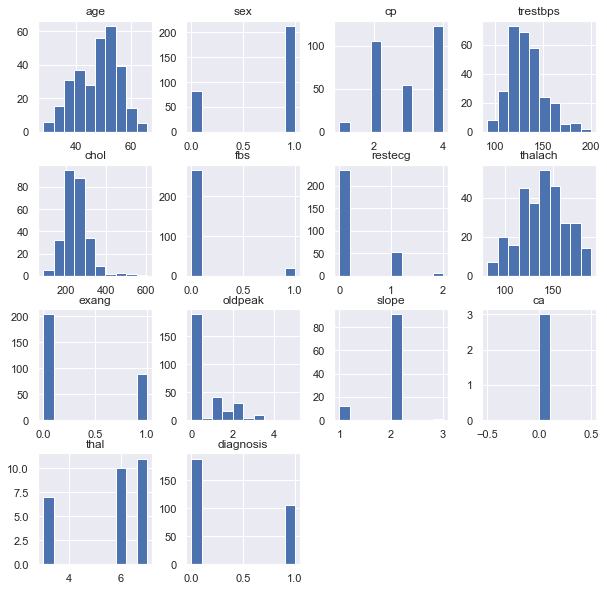

In [60]:
sns.set()
hungarian_df.hist(figsize=(10,10))
#plt.savefig('heart_disease_hist.png', dpi=300, bbox_inches='tight')
plt.show()

<AxesSubplot:xlabel='diagnosis', ylabel='Count'>

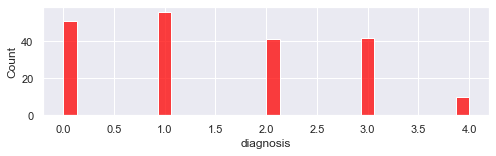

In [30]:
fig, ax = plt.subplots(figsize=(8, 2)) # Create a new figure with size (8, 2)
sns.set_style('whitegrid')
sns.histplot(va_df['diagnosis'], kde=False, color='red', bins=30, ax=ax) # Add the plot to the specified axis
# plt.savefig('diagnosis_distribution.png', dpi=300, bbox_inches='tight')

## Pre-Processing

In [61]:
import os
import pandas as pd
import sklearn
import sklearn.model_selection
import sklearn.preprocessing
import sklearn.pipeline
import numpy as np
from sklearn.impute import SimpleImputer 

In [62]:
CONTINUOUS_FACTORS = ["age", "chol", "oldpeak", "thalach", "trestbps"]
DISCRETE_FACTORS = ["ca", "cp", "exang", "fbs", "restecg", "sex", "slope", "thal"]
TARGET = ["diagnosis"]

 
train, test = sklearn.model_selection.train_test_split(heart_disease_df, test_size=.2, random_state=10)

# split the data into the X and Y variables
trainY = train["diagnosis"].copy()
trainX = train.drop("diagnosis", axis=1)
testY = test["diagnosis"].copy()
testX = test.drop("diagnosis", axis=1)

# Handle the discrete and continuous variables seperatly
trainX_continuous = trainX[CONTINUOUS_FACTORS]
trainX_discrete = trainX[DISCRETE_FACTORS].fillna(value=5) #For all the discrete values, replace missing values with 5
testX_continuous = testX[CONTINUOUS_FACTORS]
testX_discrete = testX[DISCRETE_FACTORS].fillna(value=5) #For all the discrete values, replace missing values with 5

In [63]:
 # For continuous variables, replace missing values with the median and then normalize by subtracting the mean and dividing by the standard deviation
imp = SimpleImputer(missing_values=np.nan, strategy='mean')

continuous_Pipeline = sklearn.pipeline.Pipeline( [("imputer", sklearn.impute.SimpleImputer(strategy="median")),
                                             ("scaler", sklearn.preprocessing.StandardScaler())
                                            ]
                                           )
trainX_continuous_scaled = continuous_Pipeline.fit_transform(trainX_continuous)

In [64]:
# for discrete variables, one-hot encode the data
discrete_Pipeline = sklearn.pipeline.Pipeline( [("one_hot", sklearn.preprocessing.OneHotEncoder(handle_unknown ='ignore'))
                                            ]
                                           )
trainX_discrete_one_hot = discrete_Pipeline.fit_transform(trainX_discrete)

print(np.size(trainX_discrete, 1))
print(np.size(trainX_discrete_one_hot, 1))


8
29


The one hot encoding increases the number of features from 8 to 29, since artificially zeros are introduced. 

In [65]:
trainX_fully_preprocessed = np.concatenate((trainX_continuous_scaled, trainX_discrete_one_hot.toarray()), axis = 1)

print(trainX_continuous_scaled.shape)
print(trainX_discrete_one_hot.shape)

print(trainX_fully_preprocessed.shape)

(736, 5)
(736, 29)
(736, 34)


## In the literature, only the Cleveland database was used by ML engineers. 

In [71]:
CONTINUOUS_FACTORS = ["age", "chol", "oldpeak", "thalach", "trestbps"]
DISCRETE_FACTORS = ["ca", "cp", "exang", "fbs", "restecg", "sex", "slope", "thal"]
TARGET = ["diagnosis"]

 
train_cl, test_cl = sklearn.model_selection.train_test_split(cleveland_df, test_size=.2, random_state=10)

# split the data into the X and Y variables
trainY_cl = train_cl["diagnosis"].copy()
trainX_cl = train_cl.drop("diagnosis", axis=1)
testY_cl = test_cl["diagnosis"].copy()
testX_cl = test_cl.drop("diagnosis", axis=1)

# Handle the discrete and continuous variables seperatly
trainX_continuous_cl = trainX_cl[CONTINUOUS_FACTORS]
trainX_discrete_cl = trainX_cl[DISCRETE_FACTORS].fillna(value=5) #For all the discrete values, replace missing values with 5
testX_continuous_cl = testX_cl[CONTINUOUS_FACTORS]
testX_discrete_cl = testX_cl[DISCRETE_FACTORS].fillna(value=5) #For all the discrete values, replace missing values with 5

 # For continuous variables, replace missing values with the median and then normalize by subtracting the mean and dividing by the standard deviation
imp = SimpleImputer(missing_values=np.nan, strategy='mean')

# Standard scaler
continuous_Pipeline = sklearn.pipeline.Pipeline( [("imputer", sklearn.impute.SimpleImputer(strategy="median")),
                                             ("scaler", sklearn.preprocessing.StandardScaler())
                                            ]
                                           )


trainX_continuous_scaled_cl = continuous_Pipeline.fit_transform(trainX_continuous_cl)

# for discrete variables, one-hot encode the data
discrete_Pipeline = sklearn.pipeline.Pipeline( [("one_hot", sklearn.preprocessing.OneHotEncoder(handle_unknown ='ignore'))
                                            ]
                                           )
trainX_discrete_one_hot_cl = discrete_Pipeline.fit_transform(trainX_discrete_cl)


trainX_fully_preprocessed_cl = np.concatenate((trainX_continuous_scaled_cl, trainX_discrete_one_hot_cl.toarray()), axis = 1)

## Hungarian Dataframe

In [72]:
CONTINUOUS_FACTORS = ["age", "chol", "oldpeak", "thalach", "trestbps"]
DISCRETE_FACTORS = ["ca", "cp", "exang", "fbs", "restecg", "sex", "slope", "thal"]
TARGET = ["diagnosis"]

 
train_hg, test_hg = sklearn.model_selection.train_test_split(hungarian_df, test_size=.2, random_state=10)

# split the data into the X and Y variables
trainY_hg = train_hg["diagnosis"].copy()
trainX_hg = train_hg.drop("diagnosis", axis=1)
testY_hg = test_hg["diagnosis"].copy()
testX_hg = test_hg.drop("diagnosis", axis=1)

# Handle the discrete and continuous variables seperatly
trainX_continuous_hg = trainX_hg[CONTINUOUS_FACTORS]
trainX_discrete_hg = trainX_hg[DISCRETE_FACTORS].fillna(value=5) #For all the discrete values, replace missing values with 5
testX_continuous_hg = testX_hg[CONTINUOUS_FACTORS]
testX_discrete_hg = testX_hg[DISCRETE_FACTORS].fillna(value=5) #For all the discrete values, replace missing values with 5

 # For continuous variables, replace missing values with the median and then normalize by subtracting the mean and dividing by the standard deviation
imp = SimpleImputer(missing_values=np.nan, strategy='mean')

# Standard scaler
continuous_Pipeline = sklearn.pipeline.Pipeline( [("imputer", sklearn.impute.SimpleImputer(strategy="median")),
                                             ("scaler", sklearn.preprocessing.StandardScaler())
                                            ]
                                           )


trainX_continuous_scaled_hg = continuous_Pipeline.fit_transform(trainX_continuous_hg)

# for discrete variables, one-hot encode the data
discrete_Pipeline = sklearn.pipeline.Pipeline( [("one_hot", sklearn.preprocessing.OneHotEncoder(handle_unknown ='ignore'))
                                            ]
                                           )
trainX_discrete_one_hot_hg = discrete_Pipeline.fit_transform(trainX_discrete_hg)


trainX_fully_preprocessed_hg = np.concatenate((trainX_continuous_scaled_hg, trainX_discrete_one_hot_hg.toarray()), axis = 1)

In [73]:
# preprocess the test data, note the use of transform instead of fit_transform
testX_continuous_scaled = continuous_Pipeline.transform(testX_continuous)
testX_discrete_one_hot = discrete_Pipeline.transform(testX_discrete)
testX_fully_preprocessed = np.concatenate((testX_continuous_scaled, testX_discrete_one_hot.toarray()), axis = 1)

# now repeat only for Cleveland Database
testX_continuous_scaled_cl = continuous_Pipeline.transform(testX_continuous_cl)
testX_discrete_one_hot_cl = discrete_Pipeline.transform(testX_discrete_cl)
testX_fully_preprocessed_cl = np.concatenate((testX_continuous_scaled_cl, testX_discrete_one_hot_cl.toarray()), axis = 1)

# now repeat only for Hungarian Database
testX_continuous_scaled_hg = continuous_Pipeline.transform(testX_continuous_hg)
testX_discrete_one_hot_hg = discrete_Pipeline.transform(testX_discrete_hg)
testX_fully_preprocessed_hg = np.concatenate((testX_continuous_scaled_hg, testX_discrete_one_hot_hg.toarray()), axis = 1)

In [68]:
print(trainX_continuous_scaled_cl.shape)
print(trainX_discrete_one_hot_cl.shape)

print(trainX_fully_preprocessed_cl.shape)
print(testX_fully_preprocessed_cl.shape)

(242, 5)
(242, 25)
(242, 30)
(61, 30)


In [74]:
print(trainX_continuous_scaled_hg.shape)
print(trainX_discrete_one_hot_hg.shape)

print(trainX_fully_preprocessed_hg.shape)
print(testX_fully_preprocessed_hg.shape)

(235, 5)
(235, 25)
(235, 30)
(59, 30)


In [75]:
# Convert the Y varialbe to a binary varible
trainY_binary = (trainY>0) # True if they have heart disease, False otherwide
testY_binary = (testY>0) # True if they have heart disease, False otherwide

trainY_binary_cl = (trainY_cl>0) # True if they have heart disease, False otherwide
testY_binary_cl = (testY_cl>0) # True if they have heart disease, False otherwide

trainY_binary_hg = (trainY_hg>0) # True if they have heart disease, False otherwide
testY_binary_hg = (testY_hg>0) # True if they have heart disease, False otherwide

In [ ]:
print(trainX_fully_preprocessed.shape)
print(testX_fully_preprocessed.shape)
print(trainY_binary.shape)
print(testY_binary.shape)

print(trainX_fully_preprocessed_cl.shape)
print(testX_fully_preprocessed_cl.shape)
print(trainY_binary_cl.shape)
print(testY_binary_cl.shape)

Preprocessing done. There are two datasets: trainY_binary and trainY. 

# Train models for full dataset

### Linear Regression

Let's write 2 helper functions of calculating and printing evaluation metrics.

In [79]:
from sklearn.metrics import mean_squared_error, r2_score

# Calculate and print the evaluation metrics
def print_evaluation_metrics(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    
    print(f'Mean Squared Error: {mse:.4f}')
    print(f'R-squared: {r2:.4f}')

In [80]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# Calculate and print the classification metrics
def print_classification_metrics(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    roc_auc = roc_auc_score(y_true, y_pred)
    
    print(f'Accuracy: {accuracy:.4f}')
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'F1 Score: {f1:.4f}')
    print(f'ROC AUC Score: {roc_auc:.4f}')

In [ ]:
print(trainX_fully_preprocessed.shape)
print(testX_fully_preprocessed.shape)
print(trainY_binary.shape)
print(testY_binary.shape)

In [ ]:
from sklearn.linear_model import LinearRegression

# Create a linear regression model
linear_reg = LinearRegression()

# Fit the model to the training data
linear_reg.fit(trainX_fully_preprocessed, trainY_binary)

# Predict the target values for the test data
testY_pred = linear_reg.predict(testX_fully_preprocessed)

# Since linear regression returns continuous values, we need to convert the predictions into binary classification
lin_testY_pred_binary = (testY_pred >= 0.5).astype(int)

# Calculate and print the evaluation and classification metrics
print_evaluation_metrics(testY_binary, testY_pred)
print_classification_metrics(testY_binary, lin_testY_pred_binary)

Next, we try to optimise the type of the regularization and the regularization strength .

In [ ]:
from sklearn.linear_model import Ridge, Lasso
from sklearn.model_selection import GridSearchCV

# Assuming trainX_fully_preprocessed, trainY_binary are loaded as NumPy arrays or pandas DataFrames

# Define the hyperparameters to optimize
params = {
    'alpha': np.logspace(-4, 4, 9)  # Regularization strength
}

# Create Ridge and Lasso models
ridge = Ridge()
lasso = Lasso()

# Create GridSearchCV objects for Ridge and Lasso
ridge_grid = GridSearchCV(ridge, params, scoring='neg_mean_squared_error', cv=5)
lasso_grid = GridSearchCV(lasso, params, scoring='neg_mean_squared_error', cv=5)

# Fit the GridSearchCV objects to the training data
ridge_grid.fit(trainX_fully_preprocessed, trainY_binary)
lasso_grid.fit(trainX_fully_preprocessed, trainY_binary)

# Get the best hyperparameters and models
best_ridge_params = ridge_grid.best_params_
best_lasso_params = lasso_grid.best_params_
best_ridge_model = ridge_grid.best_estimator_
best_lasso_model = lasso_grid.best_estimator_

print(f'Best Ridge parameters: {best_ridge_params}')
print(f'Best Lasso parameters: {best_lasso_params}')

In [ ]:
# Make predictions using the best Ridge and Lasso models
ridge_testY_pred = best_ridge_model.predict(testX_fully_preprocessed)
lasso_testY_pred = best_lasso_model.predict(testX_fully_preprocessed)

# Convert the continuous predictions into binary classification
ridge_testY_pred_binary = (ridge_testY_pred >= 0.5).astype(int)
lasso_testY_pred_binary = (lasso_testY_pred >= 0.5).astype(int)

# Calculate and print the evaluation metrics for Ridge model
print("Ridge Model:")
print_evaluation_metrics(testY_binary, ridge_testY_pred)
print_classification_metrics(testY_binary, ridge_testY_pred_binary)

# Calculate and print the evaluation metrics for Lasso model
print("\nLasso Model:")
print_evaluation_metrics(testY_binary, lasso_testY_pred)
print_classification_metrics(testY_binary, lasso_testY_pred_binary)

### Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression

# Create a logistic regression model
logistic_reg = LogisticRegression(max_iter=1000)

# Fit the model to the training data
logistic_reg.fit(trainX_fully_preprocessed, trainY_binary)

# Predict the target values for the test data
testY_pred = logistic_reg.predict(testX_fully_preprocessed)

# Calculate and print the evaluation metrics
print_classification_metrics(testY_binary, testY_pred)

In [ ]:
# Define the hyperparameters to optimize
params = {
    'C': np.logspace(-4, 4, 9),  # Inverse of regularization strength
    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
}

# Create a logistic regression model
logistic_reg = LogisticRegression(max_iter=3000)

# Create a GridSearchCV object for logistic regression
logistic_grid = GridSearchCV(logistic_reg, params, scoring='accuracy', cv=5)

# Fit the GridSearchCV object to the training data
logistic_grid.fit(trainX_fully_preprocessed, trainY_binary)

# Get the best hyperparameters and model
best_logistic_params = logistic_grid.best_params_
best_logistic_model = logistic_grid.best_estimator_

print(f'Best logistic regression parameters: {best_logistic_params}')

In [ ]:
logistic_testY_pred = best_logistic_model.predict(testX_fully_preprocessed)

print_classification_metrics(testY_binary, logistic_testY_pred)

### Support Vector Machines


In [ ]:
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV

# Create a Support vector model
svm = SVC()

# Fit the model to the training data
svm.fit(trainX_fully_preprocessed, trainY_binary)

# Predict the target values for the test data
testY_pred = svm.predict(testX_fully_preprocessed)

# Calculate and print the evaluation metrics
print_classification_metrics(testY_binary, testY_pred)

In [ ]:
from sklearn.model_selection import GridSearchCV

# Define the hyperparameters to optimize
params = {
    'C': [0.1, 1, 10, 100],  # Regularization parameter
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],  # Kernel function
    'gamma': ['scale', 'auto']  # Kernel coefficient for rbf, poly and sigmoid
}

# Create a GridSearchCV object for SVM
svm_grid = GridSearchCV(svm, params, scoring='accuracy', cv=5)

# Fit the GridSearchCV object to the training data
svm_grid.fit(trainX_fully_preprocessed, trainY_binary)

# Get the best hyperparameters and model
best_svm_params = svm_grid.best_params_
best_svm_model = svm_grid.best_estimator_


print(f'Best SVM parameters: {best_svm_params}')

In [ ]:
svm_testY_pred = best_svm_model.predict(testX_fully_preprocessed)
print_classification_metrics(testY_binary, svm_testY_pred)

print('')
svm_trainY_pred = best_svm_model.predict(trainX_fully_preprocessed)
print_classification_metrics(trainY_binary, svm_trainY_pred)


### Neural Network classifier

In [ ]:
from sklearn.neural_network import MLPClassifier

# Create a neural network classifier model
mlp = MLPClassifier(max_iter = 2000, solver = 'adam')

# Fit the model to the training data
mlp.fit(trainX_fully_preprocessed, trainY_binary)

# Predict the target values for the test data
testY_pred_nn = mlp.predict(testX_fully_preprocessed)

# Calculate and print the evaluation metrics
print_classification_metrics(testY_binary, testY_pred_nn)

In [ ]:
from sklearn.model_selection import GridSearchCV

# Define the hyperparameters to optimize
params = {
    'hidden_layer_sizes': [(1,), (2,), (1, 1), (2, 2)],  # Number of neurons in each hidden layer
    'activation': ['identity', 'logistic', 'tanh', 'relu'],  # Activation function for the hidden layer
    'solver': ['adam', 'sgd'],  # Optimizer for weight optimization
    'alpha': [0.0001, 0.001, 0.01],  # L2 penalty (regularization term)
    'learning_rate': ['constant', 'invscaling', 'adaptive']  # Learning rate schedule for weight updates
}

# Create a neural network classifier model
mlp = MLPClassifier(max_iter = 3000, solver = 'adam')

# Create a GridSearchCV object for the neural network classifier
mlp_grid = GridSearchCV(mlp, params, scoring='accuracy', cv=5)

# Fit the GridSearchCV object to the training data
mlp_grid.fit(trainX_fully_preprocessed, trainY_binary)

# Get the best hyperparameters and model
best_mlp_params = mlp_grid.best_params_
best_mlp_model = mlp_grid.best_estimator_

In [ ]:
neural_network_testY_pred = best_mlp_model.predict(testX_fully_preprocessed)

print_classification_metrics(testY_binary, neural_network_testY_pred)

print('')
neural_network_trainY_pred = best_mlp_model.predict(trainX_fully_preprocessed)

print_classification_metrics(trainY_binary, neural_network_trainY_pred)


Compare results of all classifications only for optimized hyperparameters.

In [ ]:
# lin regression
print('lin reg lasso')
# print_classification_metrics(testY_binary, lasso_testY_pred_binary)
print('')
print('lin reg ridge')
# print_classification_metrics(testY_binary, ridge_testY_pred_binary)
print('')
# log regression
print('log reg')
# print_classification_metrics(testY_binary, logistic_testY_pred)
print('')
# svm
print('svm')
# print_classification_metrics(testY_binary, svm_testY_pred)
print('')
# nn
print('neural network')
# print_classification_metrics(testY_binary, neural_network_testY_pred)

In [ ]:
def evaluate_classification_model(model, testX, testY, threshold=0.5):
    '''
    Evaluates a binary classification model on the test set
    Returns a dictionary with the evaluation metrics
    '''
    predY = model.predict(testX) > threshold
    
    acc = accuracy_score(testY, predY)
    prec = precision_score(testY, predY)
    rec = recall_score(testY, predY)
    f1 = f1_score(testY, predY)
    roc_auc = roc_auc_score(testY, predY)
    
    return {'Accuracy': acc,
            'Precision': prec,
            'Recall': rec,
            'F1 Score': f1,
            'ROC AUC Score': roc_auc}

In [ ]:
from tabulate import tabulate

# Evaluation metrics dictionary for each model
lasso_metrics = evaluate_classification_model(best_lasso_model, testX_fully_preprocessed, testY_binary)
ridge_metrics = evaluate_classification_model(best_ridge_model, testX_fully_preprocessed, testY_binary)
logistic_metrics = evaluate_classification_model(best_logistic_model, testX_fully_preprocessed, testY_binary)
svm_metrics = evaluate_classification_model(best_svm_model, testX_fully_preprocessed, testY_binary)
nn_metrics = evaluate_classification_model(best_mlp_model, testX_fully_preprocessed, testY_binary)

# Create a pandas DataFrame for the evaluation metrics
results = pd.DataFrame({'Model': ['Lasso Regression', 'Ridge Regression', 'Logistic Regression', 'SVM', 'Neural Network'],
                   'Accuracy': [lasso_metrics['Accuracy'], ridge_metrics['Accuracy'], logistic_metrics['Accuracy'], svm_metrics['Accuracy'], nn_metrics['Accuracy']],
                   'Precision': [lasso_metrics['Precision'], ridge_metrics['Precision'], logistic_metrics['Precision'], svm_metrics['Precision'], nn_metrics['Precision']],
                   'Recall': [lasso_metrics['Recall'], ridge_metrics['Recall'], logistic_metrics['Recall'], svm_metrics['Recall'], nn_metrics['Recall']],
                   'F1 Score': [lasso_metrics['F1 Score'], ridge_metrics['F1 Score'], logistic_metrics['F1 Score'], svm_metrics['F1 Score'], nn_metrics['F1 Score']],
                   'ROC AUC Score': [lasso_metrics['ROC AUC Score'], ridge_metrics['ROC AUC Score'], logistic_metrics['ROC AUC Score'], svm_metrics['ROC AUC Score'], nn_metrics['ROC AUC Score']]})


df = pd.DataFrame(results)
print(df)

# Here are the confusion matrices for all models.

In [ ]:
cm_lasso = confusion_matrix(testY_binary,lasso_testY_pred_binary)
cm_ridge = confusion_matrix(testY_binary,ridge_testY_pred_binary)
cm_log = confusion_matrix(testY_binary,logistic_testY_pred)
cm_svm = confusion_matrix(testY_binary,svm_testY_pred)
cm_nn = confusion_matrix(testY_binary,neural_network_testY_pred)

group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
                cm_lasso.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cm_lasso.flatten()/np.sum(cm_lasso)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cm_lasso, annot=labels, fmt="", cmap='Blues')

In [ ]:
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
                cm_ridge.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cm_ridge.flatten()/np.sum(cm_ridge)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cm_ridge, annot=labels, fmt="", cmap='Blues')


In [ ]:
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
                cm_log.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cm_log.flatten()/np.sum(cm_log)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cm_log, annot=labels, fmt="", cmap='Blues')

In [ ]:
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
                cm_svm.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cm_svm.flatten()/np.sum(cm_svm)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cm_svm, annot=labels, fmt="", cmap='Blues')

In [ ]:
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
                cm_nn.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cm_nn.flatten()/np.sum(cm_nn)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cm_nn, annot=labels, fmt="", cmap='Blues')

# Train models for Cleveland dataset

Now, to not change all variable names, we overwrite the variable names of the fully preprocessed dataset with the Cleveland preprocessed dataset. This step is essential!

In [ ]:
trainX_fully_preprocessed = trainX_fully_preprocessed_cl
testX_fully_preprocessed = testX_fully_preprocessed_cl
trainY_binary = trainY_binary_cl
testY_binary = testY_binary_cl

In [ ]:
print(trainX_fully_preprocessed.shape)
print(testX_fully_preprocessed.shape)
print(trainY_binary.shape)
print(testY_binary.shape)

#print(trainX_fully_preprocessed_cl.shape)
#print(testX_fully_preprocessed_cl.shape)
#print(trainY_binary_cl.shape)
#print(testY_binary_cl.shape)


Linear Regression

In [ ]:
from sklearn.linear_model import LinearRegression

# Create a linear regression model
linear_reg = LinearRegression()

# Fit the model to the training data
linear_reg.fit(trainX_fully_preprocessed, trainY_binary)

# Predict the target values for the test data
testY_pred = linear_reg.predict(testX_fully_preprocessed)

# Since linear regression returns continuous values, we need to convert the predictions into binary classification
lin_testY_pred_binary = (testY_pred >= 0.5).astype(int)

# Calculate and print the evaluation and classification metrics
print_evaluation_metrics(testY_binary, testY_pred)
print_classification_metrics(testY_binary, lin_testY_pred_binary)

In [ ]:
cm_linear = confusion_matrix(testY_binary,lin_testY_pred_binary)

group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
                cm_linear.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cm_linear.flatten()/np.sum(cm_linear)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cm_linear, annot=labels, fmt="", cmap='Blues')

plt.savefig('cm_lin.png')

In [ ]:
from sklearn.linear_model import Ridge, Lasso
from sklearn.model_selection import GridSearchCV

# Assuming trainX_fully_preprocessed, trainY_binary are loaded as NumPy arrays or pandas DataFrames

# Define the hyperparameters to optimize
params = {
    'alpha': np.logspace(-4, 4, 9)  # Regularization strength
}

# Create Ridge and Lasso models
ridge = Ridge()
lasso = Lasso()

# Create GridSearchCV objects for Ridge and Lasso
ridge_grid = GridSearchCV(ridge, params, scoring='neg_mean_squared_error', cv=5)
lasso_grid = GridSearchCV(lasso, params, scoring='neg_mean_squared_error', cv=5)

# Fit the GridSearchCV objects to the training data
ridge_grid.fit(trainX_fully_preprocessed, trainY_binary)
lasso_grid.fit(trainX_fully_preprocessed, trainY_binary)

# Get the best hyperparameters and models
best_ridge_params = ridge_grid.best_params_
best_lasso_params = lasso_grid.best_params_
best_ridge_model = ridge_grid.best_estimator_
best_lasso_model = lasso_grid.best_estimator_

print(f'Best Ridge parameters: {best_ridge_params}')
print(f'Best Lasso parameters: {best_lasso_params}')

In [ ]:
# Make predictions using the best Ridge and Lasso models
ridge_testY_pred = best_ridge_model.predict(testX_fully_preprocessed)
lasso_testY_pred = best_lasso_model.predict(testX_fully_preprocessed)

# Convert the continuous predictions into binary classification
ridge_testY_pred_binary = (ridge_testY_pred >= 0.5).astype(int)
lasso_testY_pred_binary = (lasso_testY_pred >= 0.5).astype(int)

# Calculate and print the evaluation metrics for Ridge model
print("Ridge Model:")
print_evaluation_metrics(testY_binary, ridge_testY_pred)
print_classification_metrics(testY_binary, ridge_testY_pred_binary)

# Calculate and print the evaluation metrics for Lasso model
print("\nLasso Model:")
print_evaluation_metrics(testY_binary, lasso_testY_pred)
print_classification_metrics(testY_binary, lasso_testY_pred_binary)

In [ ]:
cm_lasso = confusion_matrix(testY_binary,lasso_testY_pred_binary)

group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
                cm_lasso.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cm_lasso.flatten()/np.sum(cm_lasso)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cm_lasso, annot=labels, fmt="", cmap='Blues')

plt.savefig('cm_lasso.png')

In [ ]:
cm_ridge = confusion_matrix(testY_binary,ridge_testY_pred_binary)

group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
                cm_ridge.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cm_ridge.flatten()/np.sum(cm_ridge)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cm_ridge, annot=labels, fmt="", cmap='Blues')

plt.savefig('cm_ridge.png')

Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression

# Create a logistic regression model
logistic_reg = LogisticRegression(max_iter=1000)

# Fit the model to the training data
logistic_reg.fit(trainX_fully_preprocessed, trainY_binary)

# Predict the target values for the test data
testY_pred_log = logistic_reg.predict(testX_fully_preprocessed)

# Calculate and print the evaluation metrics
print_classification_metrics(testY_binary, testY_pred_log)

In [ ]:
# Define the hyperparameters to optimize
params = {
    'C': np.logspace(-4, 4, 9),  # Inverse of regularization strength
    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
}

# Create a logistic regression model
logistic_reg = LogisticRegression(max_iter=3000)

# Create a GridSearchCV object for logistic regression
logistic_grid = GridSearchCV(logistic_reg, params, scoring='accuracy', cv=10)

# Fit the GridSearchCV object to the training data
logistic_grid.fit(trainX_fully_preprocessed, trainY_binary)

# Get the best hyperparameters and model
best_logistic_params = logistic_grid.best_params_
best_logistic_model = logistic_grid.best_estimator_

print(f'Best logistic regression parameters: {best_logistic_params}')

In [ ]:
logistic_testY_pred = best_logistic_model.predict(testX_fully_preprocessed)

print_classification_metrics(testY_binary, logistic_testY_pred)

In [ ]:
cm_log = confusion_matrix(testY_binary,logistic_testY_pred)

group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
                cm_log.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cm_log.flatten()/np.sum(cm_log)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cm_log, annot=labels, fmt="", cmap='Blues')

plt.savefig('cm_log.png')

Support Vector Machines

In [ ]:
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV

# Create a Support vector model
svm = SVC()

# Fit the model to the training data
svm.fit(trainX_fully_preprocessed, trainY_binary)

# Predict the target values for the test data
testY_pred_svm = svm.predict(testX_fully_preprocessed)

# Calculate and print the evaluation metrics
print_classification_metrics(testY_binary, testY_pred_svm)

In [ ]:
from sklearn.model_selection import GridSearchCV

# Define the hyperparameters to optimize
params = {
    'C': [0.1, 1, 10,],  # Regularization parameter
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],  # Kernel function
    'gamma': ['scale', 'auto']  # Kernel coefficient for rbf, poly and sigmoid
}

# Create a GridSearchCV object for SVM
svm_grid = GridSearchCV(svm, params, scoring='accuracy', cv=10)

# Fit the GridSearchCV object to the training data
svm_grid.fit(trainX_fully_preprocessed, trainY_binary)

# Get the best hyperparameters and model
best_svm_params = svm_grid.best_params_
best_svm_model = svm_grid.best_estimator_

print(f'Best SVM parameters: {best_svm_params}')

In [ ]:
svm_testY_pred = best_svm_model.predict(testX_fully_preprocessed)
print_classification_metrics(testY_binary, svm_testY_pred)

#svm_trainY_pred = best_svm_model.predict(trainX_fully_preprocessed)
#print_classification_metrics(trainY_binary, svm_trainY_pred)


In [ ]:
cm_svm = confusion_matrix(testY_binary,svm_testY_pred)

group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
                cm_svm.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cm_svm.flatten()/np.sum(cm_svm)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cm_svm, annot=labels, fmt="", cmap='Blues')

plt.savefig('cm_svm.png')

NN classifier

In [ ]:
from sklearn.neural_network import MLPClassifier

# Create a neural network classifier model
mlp = MLPClassifier(max_iter = 2000, solver = 'adam')

# Fit the model to the training data
mlp.fit(trainX_fully_preprocessed, trainY_binary)

# Predict the target values for the test data
testY_pred_nn = mlp.predict(testX_fully_preprocessed)

# Calculate and print the evaluation metrics
print_classification_metrics(testY_binary, testY_pred_nn)

In [ ]:
from sklearn.model_selection import GridSearchCV

# Define the hyperparameters to optimize
#params = {
#    'hidden_layer_sizes': [(30,30), (30,30,17), (30, 17, 8, 4), (17, 17 , 17)],  # Number of neurons in each hidden layer
#    'activation': ['identity', 'logistic', 'tanh', 'relu'],  # Activation function for the hidden layer
#    'solver': ['adam', 'sgd'],  # Optimizer for weight optimization
#    'alpha': [0.0001, 0.001, 0.01],  # L2 penalty (regularization term)
#    'learning_rate': ['constant', 'invscaling', 'adaptive']  # Learning rate schedule for weight updates
#}

params = {
    'hidden_layer_sizes': [(30,30), (30,30,17), (30,30,17,8)],  # Number of neurons in each hidden layer
    'activation': ['identity'],  # Activation function for the hidden layer
    'alpha': [0.00001, 0.0001],  # L2 penalty (regularization term)
    'learning_rate': ['adaptive']  # Learning rate schedule for weight updates
}


# Create a neural network classifier model
mlp = MLPClassifier(max_iter = 20000, solver = 'adam')

# Create a GridSearchCV object for the neural network classifier
mlp_grid = GridSearchCV(mlp, params, scoring='accuracy', cv=10)

# Fit the GridSearchCV object to the training data
mlp_grid.fit(trainX_fully_preprocessed, trainY_binary)

# Get the best hyperparameters and model
best_mlp_params = mlp_grid.best_params_
best_mlp_model = mlp_grid.best_estimator_

In [ ]:
neural_network_testY_pred = best_mlp_model.predict(testX_fully_preprocessed)

print_classification_metrics(testY_binary, neural_network_testY_pred)

#print('')
#neural_network_trainY_pred = best_mlp_model.predict(trainX_fully_preprocessed)

#print_classification_metrics(trainY_binary, neural_network_trainY_pred)

In [ ]:
cm_nn = confusion_matrix(testY_binary,neural_network_testY_pred)
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
                cm_nn.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cm_nn.flatten()/np.sum(cm_nn)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cm_nn, annot=labels, fmt="", cmap='Blues')

plt.savefig('cm_nn.png')

In [ ]:
len(testY_binary)

In [ ]:
print(neural_network_testY_pred)


Compare

In [ ]:
from tabulate import tabulate

# Evaluation metrics dictionary for each model
linear_metrics = evaluate_classification_model(linear_reg, testX_fully_preprocessed, testY_binary)

lasso_metrics = evaluate_classification_model(best_lasso_model, testX_fully_preprocessed, testY_binary)

ridge_metrics = evaluate_classification_model(best_ridge_model, testX_fully_preprocessed, testY_binary)

logistic_metrics = evaluate_classification_model(best_logistic_model, testX_fully_preprocessed, testY_binary)

svm_metrics = evaluate_classification_model(best_svm_model, testX_fully_preprocessed, testY_binary)

nn_metrics = evaluate_classification_model(best_mlp_model, testX_fully_preprocessed, testY_binary)

# Create a pandas DataFrame for the evaluation metrics
results = pd.DataFrame({'Model': ['Linear Regression','Lasso Regression', 'Ridge Regression', 'Logistic Regression', 'SVM', 'Neural Network'],
                   'Accuracy': [linear_metrics['Accuracy'], lasso_metrics['Accuracy'], ridge_metrics['Accuracy'], logistic_metrics['Accuracy'], svm_metrics['Accuracy'], nn_metrics['Accuracy']],
                   'Precision': [linear_metrics['Precision'], lasso_metrics['Precision'], ridge_metrics['Precision'], logistic_metrics['Precision'], svm_metrics['Precision'], nn_metrics['Precision']],
                   'Recall': [linear_metrics['Recall'], lasso_metrics['Recall'], ridge_metrics['Recall'], logistic_metrics['Recall'], svm_metrics['Recall'], nn_metrics['Recall']],
                   'F1 Score': [linear_metrics['F1 Score'], lasso_metrics['F1 Score'], ridge_metrics['F1 Score'], logistic_metrics['F1 Score'], svm_metrics['F1 Score'], nn_metrics['F1 Score']],
                   'ROC AUC Score': [linear_metrics['ROC AUC Score'], lasso_metrics['ROC AUC Score'], ridge_metrics['ROC AUC Score'], logistic_metrics['ROC AUC Score'], svm_metrics['ROC AUC Score'], nn_metrics['ROC AUC Score']]})


df = pd.DataFrame(results)
print(df)

# Cleveland vs. Hungary

In [77]:
trainX_fully_preprocessed_hg
trainY_binary_hg

trainX_fully_preprocessed_cl
trainY_binary_cl

286     True
102    False
242    False
65      True
35     False
       ...  
156     True
123     True
15     False
125    False
265     True
Name: diagnosis, Length: 242, dtype: bool

Best SVM parameters: {'C': 1, 'gamma': 'scale', 'kernel': 'sigmoid'}
Accuracy: 0.6553
Precision: 0.5091
Recall: 0.3415
F1 Score: 0.4088
ROC AUC Score: 0.5825


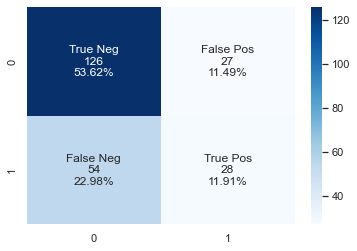

In [81]:
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV

# Create a Support vector model
svm = SVC()

# Fit the model to the training data
svm.fit(trainX_fully_preprocessed_cl, trainY_binary_cl)


# Define the hyperparameters to optimize
params = {
    'C': [0.1, 1, 10,],  # Regularization parameter
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],  # Kernel function
    'gamma': ['scale', 'auto']  # Kernel coefficient for rbf, poly and sigmoid
}

# Create a GridSearchCV object for SVM
svm_grid = GridSearchCV(svm, params, scoring='accuracy', cv=10)

# Fit the GridSearchCV object to the training data
svm_grid.fit(trainX_fully_preprocessed_cl, trainY_binary_cl)

# Get the best hyperparameters and model
best_svm_params = svm_grid.best_params_
best_svm_model = svm_grid.best_estimator_

print(f'Best SVM parameters: {best_svm_params}')

svm_testY_pred = best_svm_model.predict(trainX_fully_preprocessed_hg)
print_classification_metrics(trainY_binary_hg, svm_testY_pred)

cm_svm = confusion_matrix(trainY_binary_hg,svm_testY_pred)

group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
                cm_svm.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cm_svm.flatten()/np.sum(cm_svm)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cm_svm, annot=labels, fmt="", cmap='Blues')

plt.savefig('cm_svm.png')

## Feature selection for model accuracy improvement

print(trainX_fully_preprocessed_cl)
print(testX_fully_preprocessed_cl)
print(trainY_binary_cl)
print(testY_binary_cl)

In [ ]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

# from here old code starts which does not follow our current procedure

### SVM (old)

In [ ]:
import pandas as pd
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix

# train a SVM model using library
classifier = SVC(kernel='rbf',random_state=1,C=1,gamma='auto')
classifier.fit(trainX_fully_preprocessed,trainY)

# perform prediction on x_test data
y_pred = classifier.predict(testX_fully_preprocessed)

cm = confusion_matrix(testY,y_pred)
print(cm)
accuracy = float(cm.diagonal().sum())/len(testY)
print('model accuracy is:',accuracy*100,'%')



In [ ]:
# now use the binary data to see whether the prediction is more easibly possible
import pandas as pd
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix

# train a SVM model using library
classifier = SVC(kernel='rbf',random_state=1,C=1,gamma='auto')
classifier.fit(trainX_fully_preprocessed,trainY_binary)

# perform prediction on x_test data
y_pred_binary = classifier.predict(testX_fully_preprocessed)

cm = confusion_matrix(testY_binary,y_pred_binary)
print(cm)
accuracy = float(cm.diagonal().sum())/len(testY)
print('model accuracy is:',accuracy*100,'%')

# Calculate and print the evaluation metrics
print_classification_metrics(testY_binary, y_pred_binary)

group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
                cm.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cm.flatten()/np.sum(cm)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cm, annot=labels, fmt="", cmap='Blues')

## Neural network from class

Define activation function

In [ ]:
def sigmoidGradient(z):
    """
    computes the gradient of the sigmoid function
    """
    sigmoid = 1/(1 + np.exp(-z))
    
    return sigmoid *(1-sigmoid) 


def sigmoid(z):
    """
    return the sigmoid of z
    """
    
    return 1/ (1 + np.exp(-z))

Define cost function

Inputs for cost function:
nn_params
input_layer_size
hidden_layer_size
num_labels
X
y
Lambda

In [ ]:
def nnCostFunction(nn_params,input_layer_size, hidden_layer_size, num_labels, X, y,Lambda):
    """
    nn_params contains the parameters unrolled into a vector
    
    compute the cost and gradient of the neural network
    """
    # Reshape nn_params back into the parameters Theta1 and Theta2
    Theta1 = nn_params[:((input_layer_size+1) * hidden_layer_size)].reshape(hidden_layer_size,input_layer_size+1)
    Theta2 = nn_params[((input_layer_size +1)* hidden_layer_size ):].reshape(num_labels,hidden_layer_size+1)
    
    m = X.shape[0]
    J=0
    X = np.hstack((np.ones((m,1)),X))
    y10 = np.zeros((m,num_labels))
    
    a1 = sigmoid(X @ Theta1.T)
    a1 = np.hstack((np.ones((m,1)), a1)) # hidden layer
    a2 = sigmoid(a1 @ Theta2.T) # output layer
    
    for i in range(1,num_labels+1):
        # y10[:,i-1][:,np.newaxis] = np.where(y==i,1,0)
        y10[:, i-1] = np.where(y==i, 1, 0)
    for j in range(num_labels):
        J = J + sum(-y10[:,j] * np.log(a2[:,j]) - (1-y10[:,j])*np.log(1-a2[:,j]))
    
    cost = 1/m* J
    reg_J = cost + Lambda/(2*m) * (np.sum(Theta1[:,1:]**2) + np.sum(Theta2[:,1:]**2))
    
    # Implement the backpropagation algorithm to compute the gradients
    
    grad1 = np.zeros((Theta1.shape))
    grad2 = np.zeros((Theta2.shape))
    
    for i in range(m):
        xi= X[i,:] # 1 X 401
        a1i = a1[i,:] # 1 X 26
        a2i =a2[i,:] # 1 X 10
        d2 = a2i - y10[i,:]
        d1 = Theta2.T @ d2.T * sigmoidGradient(np.hstack((1,xi @ Theta1.T)))
        grad1= grad1 + d1[1:][:,np.newaxis] @ xi[:,np.newaxis].T
        grad2 = grad2 + d2.T[:,np.newaxis] @ a1i[:,np.newaxis].T
        
    grad1 = 1/m * grad1
    grad2 = 1/m*grad2
    
    grad1_reg = grad1 + (Lambda/m) * np.hstack((np.zeros((Theta1.shape[0],1)),Theta1[:,1:]))
    grad2_reg = grad2 + (Lambda/m) * np.hstack((np.zeros((Theta2.shape[0],1)),Theta2[:,1:]))
    
    return cost, grad1, grad2, reg_J, grad1_reg, grad2_reg


Random initialization

In [ ]:
def randInitializeWeights(L_in, L_out):
    """
    randomly initializes the weights of a layer with L_in incoming connections and L_out outgoing connections.
    """
    
    epi = (6**1/2) / (L_in + L_out)**1/2
    
    W = np.random.rand(L_out,L_in +1) *(2*epi) -epi
    
    return W

Learning parameters using gradient descent

In [ ]:
def gradientDescentnn(X,y,initial_nn_params,alpha,num_iters,Lambda,input_layer_size, hidden_layer_size, num_labels):
    """
    Take in numpy array X, y and theta and update theta by taking num_iters gradient steps
    with learning rate of alpha
    
    return theta and the list of the cost of theta during each iteration
    """
    Theta1 = initial_nn_params[:((input_layer_size+1) * hidden_layer_size)].reshape(hidden_layer_size,input_layer_size+1)
    Theta2 = initial_nn_params[((input_layer_size +1)* hidden_layer_size ):].reshape(num_labels,hidden_layer_size+1)
    
    m=len(y)
    J_history =[]
    
    for i in range(num_iters):
        nn_params = np.append(Theta1.flatten(),Theta2.flatten())
        cost, grad1, grad2 = nnCostFunction(nn_params,input_layer_size, hidden_layer_size, num_labels,X, y,Lambda)[3:]
        Theta1 = Theta1 - (alpha * grad1)
        Theta2 = Theta2 - (alpha * grad2)
        J_history.append(cost)
    
    nn_paramsFinal = np.append(Theta1.flatten(),Theta2.flatten())
    return nn_paramsFinal , J_history

Now we need to define the parameters for our neural network. 

In [ ]:
input_layer_size  = 34
hidden_layer_size = 50
num_labels = 2
num_labels_binary = 2
alpha=0.001 #learning rate
num_iters=1000
Lambda=0.1

# X = trainX_fully_preprocessed
# y = trainY
# y_binary = trainY_binary

In [ ]:
initial_Theta1 = randInitializeWeights(input_layer_size, hidden_layer_size)
initial_Theta2 = randInitializeWeights(hidden_layer_size, num_labels)

initial_nn_params = np.append(initial_Theta1.flatten(),initial_Theta2.flatten())

nnTheta, nnJ_history = gradientDescentnn(trainX_fully_preprocessed,trainY_binary,initial_nn_params,alpha,num_iters,Lambda,input_layer_size, hidden_layer_size, num_labels)

Theta1 = nnTheta[:((input_layer_size+1) * hidden_layer_size)].reshape(hidden_layer_size,input_layer_size+1)
Theta2 = nnTheta[((input_layer_size +1)* hidden_layer_size ):].reshape(num_labels,hidden_layer_size+1)

In [ ]:
# Plot the cost function evolution during training.
#In order to say learning has finished, the cost function has to converge to a flat rate
plt.plot(nnJ_history)  #
plt.xlabel("Iteration")
plt.ylabel("$J(\Theta)$")
plt.title("Cost function using Gradient Descent")

Prediction

In [ ]:
def predict(Theta1, Theta2, X):
    """
    Predict the label of an input given a trained neural network
    """
    m= X.shape[0]
    #Add a column of ones
  
    X = np.append(np.ones((m,1)),X, axis=1)
    
    #Compute the output of the hidden layer (with sigmoid activation functions)
    z1=np.dot(X, Theta1.T)
    a1=sigmoid(z1)
    
    #Add a column of ones
    a1 = np.append(np.ones((m,1)),a1, axis=1)
    
    #Compute the output of the output layer (with sigmoid activation functions)
    z2=np.dot(a1, Theta2.T)
    a2=sigmoid(z2)
    
    return np.argmax(a2,axis=1)+1

In [ ]:
pred3 = predict(Theta1, Theta2, testX_fully_preprocessed)

m = len(testY)
pred3 = pred3.reshape(m,1)
trainY_array = testY_binary.values.reshape(m,1)

print("Training Set Accuracy:",sum(pred3==trainY_array)/m*100,"%")

## Neural Network

In [ ]:
from sklearn.neural_network import MLPClassifier

# important 
# trainX_fully_preprocessed
# testX_fully_preprocessed

# trainY
# testY

# trainY_binary
# testY_binary

In [ ]:
clf = MLPClassifier(solver='lbfgs', alpha=1e-5,hidden_layer_sizes=(34, 10), max_iter = 2000, random_state=1)

clf.fit(trainX_fully_preprocessed,trainY)


In [ ]:
nn_pred = clf.predict(trainX_fully_preprocessed)

m = len(trainY)
nn_pred = nn_pred.reshape(m,1)
trainY_array = trainY.values.reshape(m,1)

print("Training Set Accuracy:",sum(nn_pred==trainY_array)/m*100,"%")

In [ ]:
nn_pred_test = clf.predict(testX_fully_preprocessed)

m_test = len(testY)
nn_pred_test = nn_pred_test.reshape(m_test,1)
trainY_array = testY.values.reshape(m_test,1)

print("Training Set Accuracy:",sum(nn_pred_test==trainY_array)/m_test*100,"%")

In [ ]:
# plt.subplot(3, 1, 1) # row 1, col 2 index 1
# plt.plot(nn_pred_test)
# plt.subplot(3, 1, 2) # row 1, col 2 index 1
# plt.plot(testY_array)
# plt.subplot(3, 1, 3) # row 1, col 2 index 1
# plt.plot(nn_pred_test)
# plt.plot(testY_array)
cm = confusion_matrix(testY,nn_pred_test)
print(cm)
accuracy = float(cm.diagonal().sum())/len(testY)
print('model accuracy is:',accuracy*100,'%')

### Binary classification (neural networks - sklearn)

In [ ]:
clf_binary = MLPClassifier(solver='lbfgs', alpha=1e-6,hidden_layer_sizes=(34, 10), max_iter = 5000, random_state=1)

clf_binary.fit(trainX_fully_preprocessed,trainY_binary)

In [ ]:
# nn_pred_binary = clf_binary.predict(trainX_fully_preprocessed)
# m_binary = len(trainY_binary)
# nn_pred_binary = nn_pred_binary.reshape(m_binary,1)
# trainY_array_binary = trainY_binary.values.reshape(m_binary,1)
# print("Training Set Accuracy:",sum(nn_pred_binary==trainY_array_binary)/m_binary*100,"%")

In [ ]:
nn_pred_binary_test = clf_binary.predict(testX_fully_preprocessed)
m_binary_test = len(testY_binary)
nn_pred_binary_test = nn_pred_binary_test.reshape(m_binary_test,1)
testY_array= testY_binary.values.reshape(m_binary_test,1)

print("Training Set Accuracy:",sum(nn_pred_binary_test==testY_array)/m_binary_test*100,"%")

In [ ]:
cm = confusion_matrix(testY_binary,nn_pred_binary_test)
print(cm)
accuracy = float(cm.diagonal().sum())/len(testY)
print('model accuracy is:',accuracy*100,'%')

print_classification_metrics(testY_binary, nn_pred_binary_test)

group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
                cm.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cm.flatten()/np.sum(cm)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cm, annot=labels, fmt="", cmap='Blues')

Neural network - clean

In [ ]:
from sklearn.neural_network import MLPClassifier

# Create a neural  model
linear_reg = LinearRegression()

# Fit the model to the training data
linear_reg.fit(trainX_fully_preprocessed, trainY_binary)

# Predict the target values for the test data
testY_pred = linear_reg.predict(testX_fully_preprocessed)

# Since linear regression returns continuous values, we need to convert the predictions into binary classification
testY_pred_binary = (testY_pred >= 0.5).astype(int)

# Calculate and print the evaluation and classification metrics
print_evaluation_metrics(testY_binary, testY_pred)
print_classification_metrics(testY_binary, testY_pred_binary)